In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def cum_r(X, gamma):
    return np.sum([gamma**(i) * (X[i+1]-X[i])**2 for i in range(len(X)-1)])

def MH(x_current, sigma_func):
    x_proposed = x_current + sigma_func(x_current) * np.random.randn()
    log_alpha = log_normpdf(x_proposed) + log_normpdf((x_proposed-x_current)/sigma_func(x_proposed)) \
                - log_normpdf(x_current) - log_normpdf((x_current-x_proposed)/sigma_func(x_current))
    return x_proposed if np.log(np.random.rand()) < log_alpha else x_current

def log_normpdf(x):
    return -(1/2) * np.log(2*np.pi) - (1/2) * x**2

def MCMC(x0, sigma_func, n):
    X = np.zeros(n)
    X[0] = x0
    for i in range(1, n):
        X[i] = MH(X[i-1], sigma_func)
    return X

def Q(x, a, sigma_func, rew_length, gamma):
    np.random.seed(0)
    N = 100
    out = 0
    X = np.zeros(rew_length)
    X[0] = x
    for n in range(N):
        X[1] = MH(x, lambda y: a)
        X[1:] = MCMC(X[1], sigma_func, rew_length-1)
        out += (1/N) * cum_r(X, gamma)
    return out

# Policy definition
def sigma(x, theta):
    return theta[0]**2 + theta[1]**2 * abs(x)

def dsigma_theta(x, theta):
    return np.array([2*theta[0], 2*theta[1] * abs(x)])

def plot_Q_function(i, theta, w, X_aux):
    plot_interval = [np.min(X_aux), np.max(X_aux), 0, 1]
    x = np.linspace(plot_interval[0], plot_interval[1], 100)
    a = np.linspace(plot_interval[2], plot_interval[3], 100)
    X, A = np.meshgrid(x, a)
    Z_true = np.zeros_like(X)
    Z_approx = np.zeros_like(X)
    
    for ix in range(X.shape[0]):
        for iy in range(X.shape[1]):
            Z_true[ix, iy] = np.log(Q(X[ix, iy], A[ix, iy], lambda y: sigma(y, theta[:,i]), rew_length, gamma))
            Z_approx[ix, iy] = np.log(Q_w(X[ix, iy], A[ix, iy], w))
    
    plt.figure(figsize=(12, 6))
    
    # True Q values
    plt.subplot(1, 2, 1)
    plt.contourf(X, A, Z_true, 50, cmap='viridis')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('a')
    plt.title(f'True log(Q) - Episode {i+1}')
    
    # Approximated Q values
    plt.subplot(1, 2, 2)
    plt.contourf(X, A, Z_approx, 50, cmap='viridis')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('a')
    plt.title(f'Approximated log(Q) - Episode {i+1}')
    
    plt.tight_layout()
    plt.show()

In [3]:
# Initialization
x0 = 100
theta = np.zeros((2, 11))
theta[:,0] = [0.01, 0.01]
gamma = 0.9
I = 10
epi_length = 20
X = np.zeros(I * epi_length + 1)
X[0] = x0

/tmp/ipykernel_22142/1093458149.py:6: RuntimeWarning: invalid value encountered in double_scalars
  log_alpha = log_normpdf(x_proposed) + log_normpdf((x_proposed-x_current)/sigma_func(x_proposed)) \
/tmp/ipykernel_22142/1093458149.py:7: RuntimeWarning: invalid value encountered in double_scalars
  - log_normpdf(x_current) - log_normpdf((x_current-x_proposed)/sigma_func(x_current))
/tmp/ipykernel_22142/1093458149.py:50: RuntimeWarning: invalid value encountered in log
  Z_approx[ix, iy] = np.log(Q_w(X[ix, iy], A[ix, iy], w))


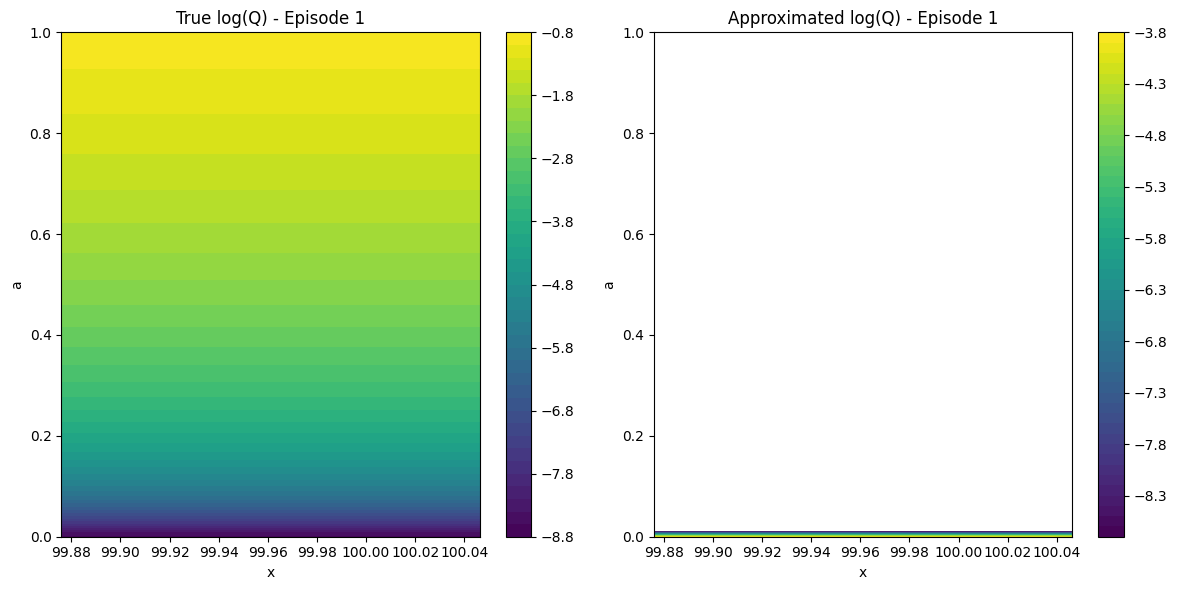

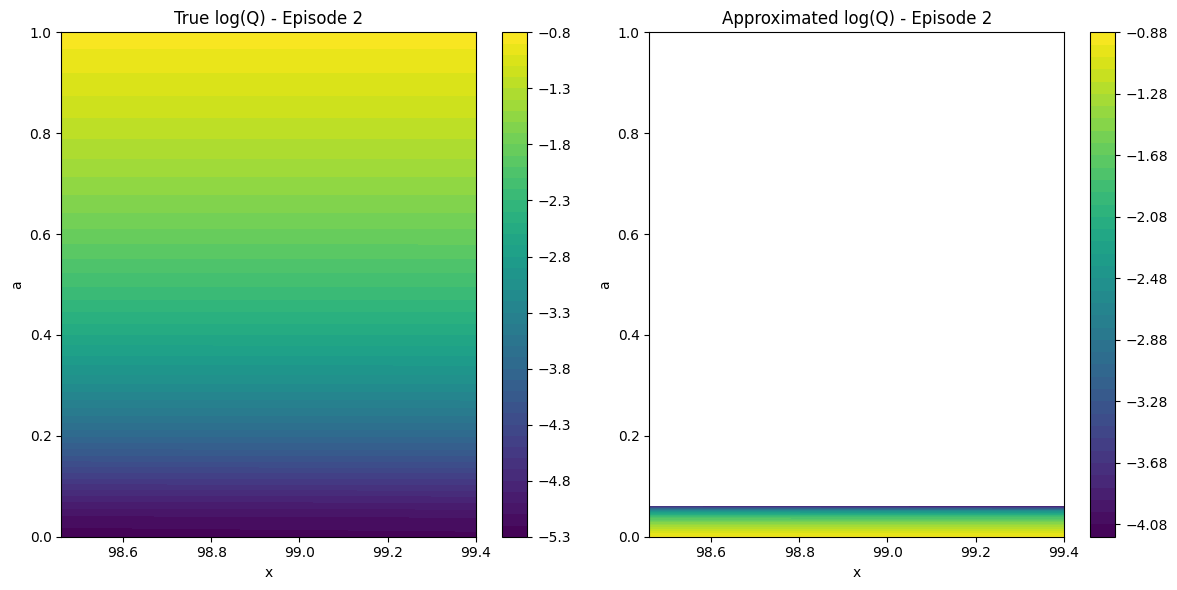

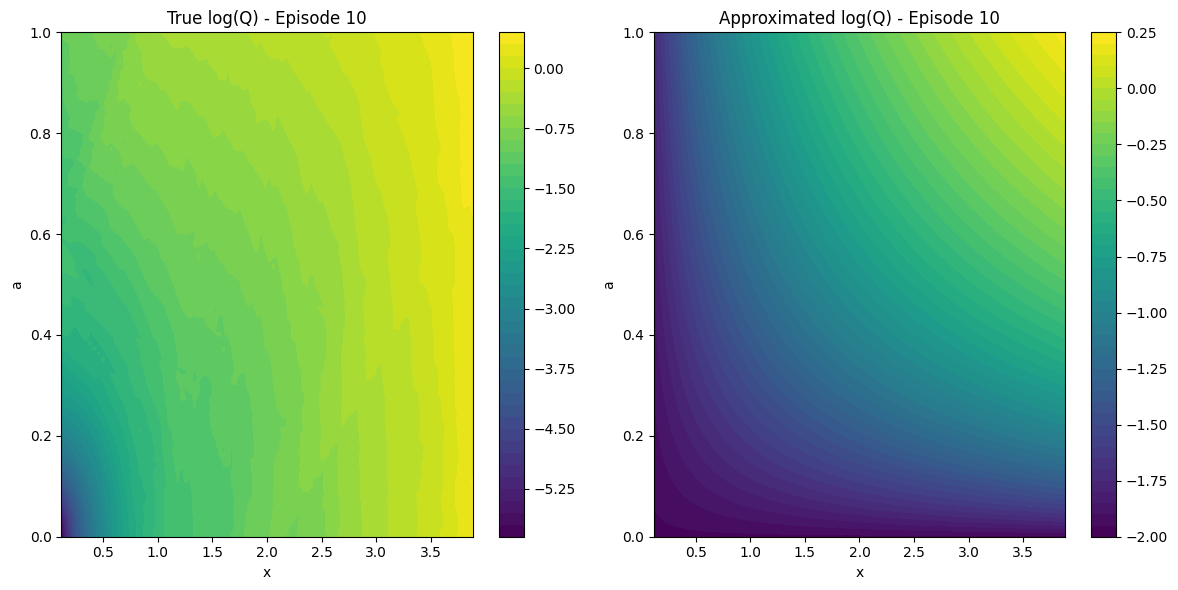

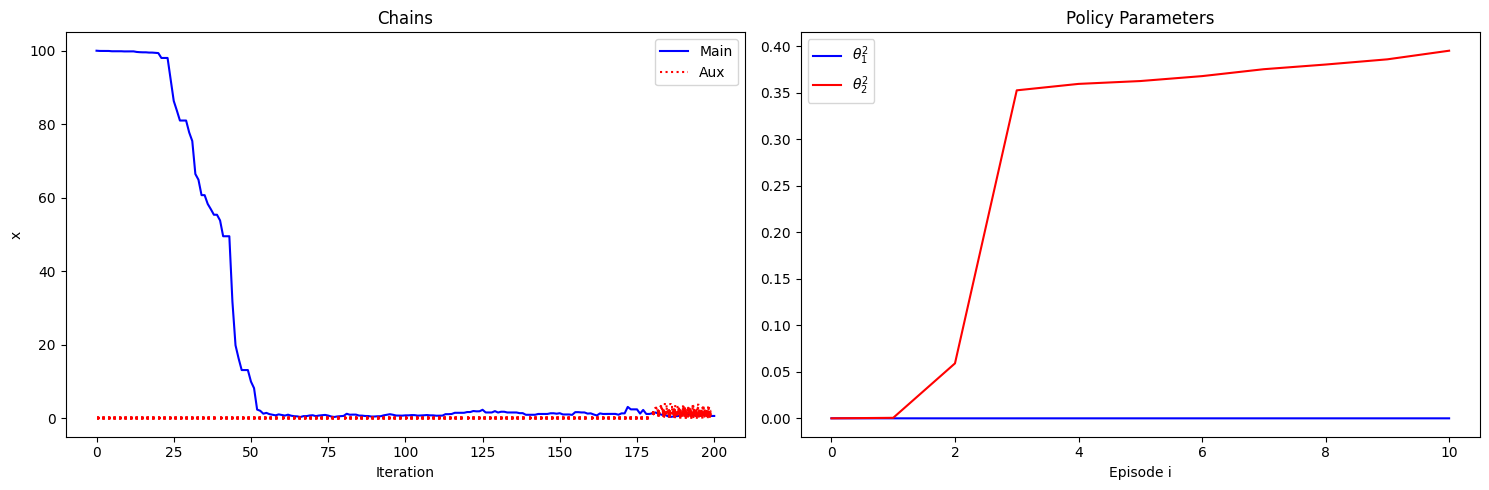

In [4]:
# Loop execution
for i in range(I):
    J = 50
    aux_length = 20
    rew_length = 5
    x0_aux = X[i * epi_length]
    X_aux = np.zeros((aux_length, J, I))
    
    for j in range(J):
        X_aux[:,j,i] = MCMC(x0_aux, lambda x: sigma(x, theta[:,i]), aux_length)
    
    x_vals = np.zeros((J, aux_length - rew_length))
    a_vals = np.zeros((J, aux_length - rew_length))
    y_vals = np.zeros((J, aux_length - rew_length))
    
    for j in range(J):
        for k in range(aux_length - rew_length):
            x_vals[j,k] = X_aux[k,j,i]
            a_vals[j,k] = sigma(x_vals[j,k], theta[:,i])
            y_vals[j,k] = cum_r(X_aux[k:k+rew_length, j, i], gamma)
    
    Q_w = lambda x, a, w: w[0] + w[1] * abs(a * x)
    dQ_a = lambda x, a, w: w[1] * np.sign(a) * abs(x)
    A = np.column_stack((np.ones(J * (aux_length - rew_length)), (a_vals.ravel() * x_vals.ravel())))
    w = np.linalg.lstsq(A, y_vals.ravel(), rcond=None)[0]
    
    # Policy gradient
    V = 0
    for j in range(J):
        for k in range(20):
            V += (1/J) * gamma**(k) * dsigma_theta(X_aux[k,j,i], theta[:,i]) \
                    * dQ_a(X_aux[k,j,i], sigma(X_aux[k,j,i], theta[:,i]), w)
    
    # Update policy
    alpha = 0.001
    theta[:,i+1] = theta[:,i] + alpha * V
    
    # Main chain
    X[i*epi_length:i*epi_length+epi_length+1] = MCMC(X[i*epi_length], 
                                                    lambda x: sigma(x, theta[:,i+1]), 
                                                    epi_length+1)

    # Plotting Q function for selected episodes
    if i in [0, 1, I-1]:
        plot_Q_function(i, theta, w, X_aux[:,:,i])

# Plotting
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X, 'b-')
for i in range(I):
    for j in range(J):
        plt.plot(range(i*epi_length, i*epi_length+aux_length), X_aux[:,j,i], 'r:')
plt.xlabel('Iteration')
plt.ylabel('x')
plt.title('Chains')
plt.legend(['Main', 'Aux'])

plt.subplot(1, 2, 2)
plt.plot(theta[0,:]**2, 'b-')
plt.plot(theta[1,:]**2, 'r-')
plt.legend([r'$\theta_1^2$', r'$\theta_2^2$'])
plt.xlabel('Episode i')
plt.title('Policy Parameters')

plt.tight_layout()
plt.show()
